# Deep Learning Course - Spring 2025 - Sharif University of Technology
## Homework 4 - VAE (100 points)

*Instructor:  Dr. Soleymani*

---

*Full Name:* Mobina Poulaei

*SID:* 403206962

---

### Variational AutoEncoder(VAE)
In this notebook we want to implement VAE and also get familiar with latent space and downstream tasks we can do with these latents.

First, lets downlaod the dataset(Fashion MNIST) and create train and test data-loaders.
These parts of code are implemented and you don't need to change them.

In [ ]:
import argparse
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

train_data = datasets.FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False,
                           transform=transforms.ToTensor())

# Set the device to GPU if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# pin memory provides improved transfer speed
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}


train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=128, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=128, shuffle=True, **kwargs)

In [ ]:
import matplotlib.pyplot as plt

def plot_image_with_label(image, label):

    # Map from numerical labels to real labels
    fashion_mnist_classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]

    # Remove the channel dimension and convert to numpy for plotting
    image = image.squeeze().numpy()

    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {fashion_mnist_classes[label]}")
    plt.axis('off')  # Hide the axes
    plt.show()

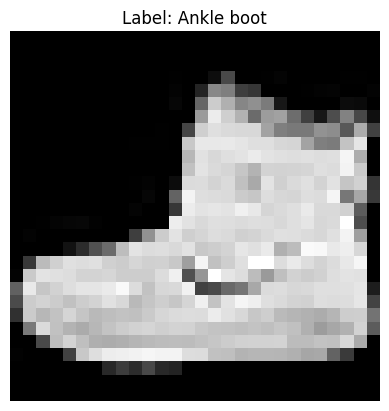

In [ ]:
plot_image_with_label(train_data[0][0], train_data[0][1])

### AutoEncoder
In this cell, you will implement an AutoEncoder. AutoEncoder consists of an encoder and a decoder. Encoder is responsible for mapping image to latent dimension where the image gets compressed in a low dimensional vector.

Fashion-MNIST images have (28, 28) shape, which is a (784, ) vector of real numbers. We want to compress this vector and just keep the most important and informational part of data (like what we do in PCA).

Then in decoder, we need to reconstruct the latent vector and recreate the given image with minimum loss. So the decoder does the opposite of what encoder does.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # define encoder layers here
        # TODO
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
        )
        # define decoder layers here
        # TODO
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )
    def encode(self, x):
        # pass x through encoder
        # TODO
        x = x.view(-1, 784)
        z = self.encoder(x)
        return z

    def decode(self, z):
        # pass z through decoder
        # TODO
        x = self.decoder(z)
        return x

    def forward(self, x):
        # call encoder and decoder
        # x: [batch size, 1, 28,28] -> x: [batch size, 784]
        # TODO
        z = self.encode(x)
        x_new = self.decode(z)
        return x_new, z

Define model, optimizer, and loss function here.
Reconstruction loss forces model to recreate given image from z latent with minimum distance.

In [ ]:
# model and optimizer
AE = AutoEncoder().to(device)
optimizer = optim.Adam(AE.parameters(), lr=1e-3)

# loss function (binary cross entropy)
def loss_function(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return BCE

Train the model with the reconstruction loss

In [ ]:
def train(epochs, model):
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, label) in enumerate(train_loader):
            # data: [batch size, 1, 28, 28]

            #call optimizer
            # TODO
            optimizer.zero_grad()
            data = data.to(device)

            # call model forward
            recon_data, z = model(data)

            # evaluate loss
            loss = loss_function(recon_data, data)
            loss.backward()
            cur_loss = loss.item()
            train_loss += cur_loss
            # call optimizer
            # TODO
            optimizer.step()

            # print loss
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100.*batch_idx / len(train_loader),
                    cur_loss/len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)
        ))

# train model
epochs = 15
train(epochs, AE)

Train Epoch: 0 [0/60000 (0%)]	Loss: 543.714539
Train Epoch: 0 [12800/60000 (21%)]	Loss: 264.774170
Train Epoch: 0 [25600/60000 (43%)]	Loss: 240.898026
Train Epoch: 0 [38400/60000 (64%)]	Loss: 246.842606
Train Epoch: 0 [51200/60000 (85%)]	Loss: 235.149994
====> Epoch: 0 Average loss: 261.4864
Train Epoch: 1 [0/60000 (0%)]	Loss: 234.344131
Train Epoch: 1 [12800/60000 (21%)]	Loss: 229.786804
Train Epoch: 1 [25600/60000 (43%)]	Loss: 238.225952
Train Epoch: 1 [38400/60000 (64%)]	Loss: 228.465424
Train Epoch: 1 [51200/60000 (85%)]	Loss: 228.070984
====> Epoch: 1 Average loss: 228.9889
Train Epoch: 2 [0/60000 (0%)]	Loss: 234.559036
Train Epoch: 2 [12800/60000 (21%)]	Loss: 217.671341
Train Epoch: 2 [25600/60000 (43%)]	Loss: 216.972549
Train Epoch: 2 [38400/60000 (64%)]	Loss: 223.372360
Train Epoch: 2 [51200/60000 (85%)]	Loss: 217.749588
====> Epoch: 2 Average loss: 222.4159
Train Epoch: 3 [0/60000 (0%)]	Loss: 218.895615
Train Epoch: 3 [12800/60000 (21%)]	Loss: 219.585190
Train Epoch: 3 [25600/

reconstruct the first image of test dataset and plot it.

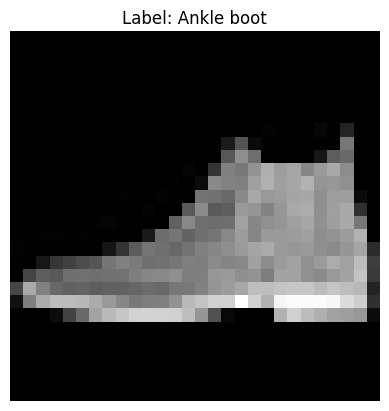

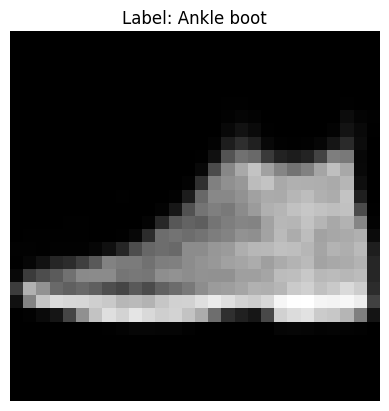

In [ ]:
image, label = test_data[0]
plot_image_with_label(image, label)

# encode and reconstruct model and plot
with torch.no_grad():
    x_decode, z = AE(image.unsqueeze(0).to(device))
    plot_image_with_label(x_decode.view(28, 28).to("cpu"), label)

Try to sampe from AE. create random latent vectors, then decode them. you would possibly face with meaningless images.

In [ ]:
def sample_from_AE():
    with torch.no_grad():
        # create random vector
        z = torch.randn(1, 128).to(device)
        #decode and plot it
        x = AE.decode(z).view(28, 28).cpu()
        plot_image_with_label(x, 1) # random label

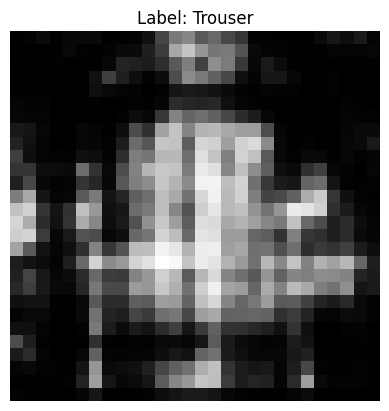

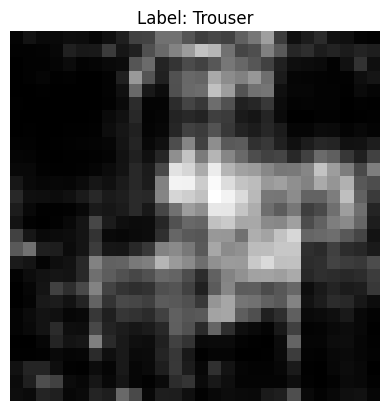

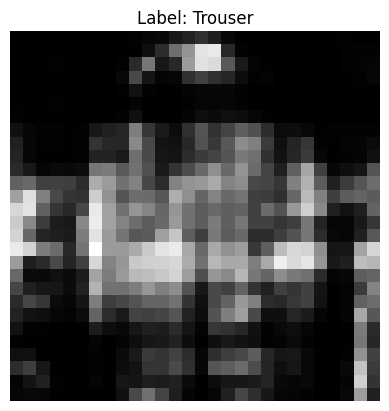

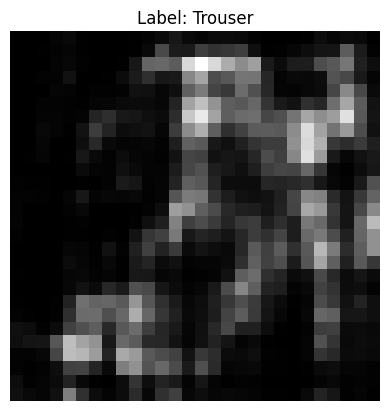

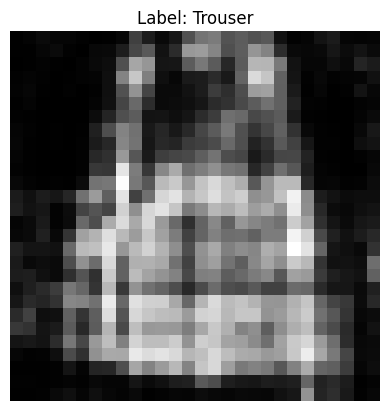

In [ ]:
for _ in range(5):
    sample_from_AE()

Sampling from this learned latent space is not possible. In a standard AE, the latent space is not structured, meaning we can't generate meaningful samples just by sampling random points.

This cell defines a **Variational Autoencoder (VAE)**, which extends a standard **AutoEncoder (AE)** by introducing probabilistic latent variables. Unlike a regular AE that directly learns a deterministic latent space, a VAE learns a **distribution** over the latent space using a **mean** and **log variance**.

## Key Additions in the VAE:
1. **Latent Distribution (`mu` & `log_var`)**  
   - Instead of mapping inputs to a single latent vector, VAE maps them to a **Gaussian distribution** with a mean (`mu`) and variance (`exp(log_var)`).
   
2. **Reparameterization Trick (`reparameterize`)**  
   - To enable backpropagation through the stochastic sampling, we use the **reparameterization trick**, where  
    
     z = mu + epsilon * sigma
    
     with **random noise** (`eps ~ N(0,1)`) and **standard deviation** (`σ = exp(0.5 * log_var)`).

3. **Sampling Function (`sample`)**  
   - Instead of encoding an input, we **directly sample** from a standard Gaussian **latent space** (`N(0, I)`) and pass it through the **decoder** to generate new samples.


In [ ]:
class VariationalAE(AutoEncoder):
    def __init__(self):
        super().__init__()

        # add log_variance layer
        # TODO
        self.latent_dim = 2
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
        )

        self.mu_layer = nn.Linear(400, self.latent_dim)
        self.log_var_layer = nn.Linear(400, self.latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        # return mu and logar
        mu = self.mu_layer(self.encoder(x))
        logvar = self.log_var_layer(self.encoder(x))
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # create normal noise, use mu and logvar to create new variable
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        # x: [batch size, 1, 28,28] -> x: [batch size, 784]
        # return renuctructed x, mu and logvar
        x = x.view(-1, 784)
        # TODO
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        new_x = self.decoder(z)
        return new_x, mu, logvar

Define model, optimizer, and loss here and then train vae.

The loss function in a Variational Autoencoder (VAE) consists of two components:

1. **Reconstruction Loss** (`criterion(decoded, images)`)  
   - Measures how well the decoded output matches the original input.  
   - Typically, Mean Squared Error (MSE) or Binary Cross-Entropy (BCE) is used.  
   - Encourages the VAE to accurately reconstruct inputs.

2. **Kullback-Leibler Divergence (KLD)**  
   ```python
   KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

**KLD** Measures how much the learned latent distribution deviates from a standard normal distribution (N(0, I)). This value is derived from the KL divergence formula between two Gaussians. It encourages the latent space to be continuous and structured, improving generative capabilities.

In [ ]:
VAE = VariationalAE().to(device)
optimizer = optim.Adam(VAE.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
def train(epochs, model):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, label) in enumerate(train_loader):
            # data: [batch size, 1, 28, 28]
            # train model
            # TODO
            optimizer.zero_grad()
            data = data.to(device)
            recon_data, mu, logvar = model(data)
            loss = loss_function(recon_data, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, train_loss / len(train_loader.dataset)))

epochs = 15
train(epochs, VAE)

Train Epoch: 0 [0/60000 (0%)]	Loss: 548.470093
Train Epoch: 0 [12800/60000 (21%)]	Loss: 299.375427
Train Epoch: 0 [25600/60000 (43%)]	Loss: 287.035706
Train Epoch: 0 [38400/60000 (64%)]	Loss: 273.784363
Train Epoch: 0 [51200/60000 (85%)]	Loss: 275.712311
====> Epoch: 0 Average loss: 292.5706
Train Epoch: 1 [0/60000 (0%)]	Loss: 276.888184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 274.924591
Train Epoch: 1 [25600/60000 (43%)]	Loss: 261.963470
Train Epoch: 1 [38400/60000 (64%)]	Loss: 276.824097
Train Epoch: 1 [51200/60000 (85%)]	Loss: 269.869324
====> Epoch: 1 Average loss: 272.0806
Train Epoch: 2 [0/60000 (0%)]	Loss: 276.938904
Train Epoch: 2 [12800/60000 (21%)]	Loss: 278.084320
Train Epoch: 2 [25600/60000 (43%)]	Loss: 268.901398
Train Epoch: 2 [38400/60000 (64%)]	Loss: 277.126678
Train Epoch: 2 [51200/60000 (85%)]	Loss: 259.383606
====> Epoch: 2 Average loss: 269.3344
Train Epoch: 3 [0/60000 (0%)]	Loss: 276.077759
Train Epoch: 3 [12800/60000 (21%)]	Loss: 284.794861
Train Epoch: 3 [25600/

Sample from VAE. Create noraml(0,1) variables then decode them and plot them.

In [ ]:
import numpy as np

def plot_multiple_images(N, images):
    images = images.numpy().squeeze(1)
    cols = int(np.ceil(np.sqrt(N)))
    rows = int(np.ceil(N / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    axes = axes.flatten()
    for i in range(rows * cols):
        if i < N:
            axes[i].imshow(images[i], cmap='gray')
            axes[i].axis('off')
        else:
            axes[i].remove()

    plt.tight_layout()
    plt.show()

def sample_from_model(N, model):
    with torch.no_grad():
        # p(z) = N(0,I), this distribution is used when calculating KLD. So we can sample z from N(0,I)
        sample = torch.randn(N, model.latent_dim).to(device)
        # decode samples
        images = model.decoder(sample).cpu().view(-1, 1, 28, 28)
        #plot them
        plot_multiple_images(N, images)

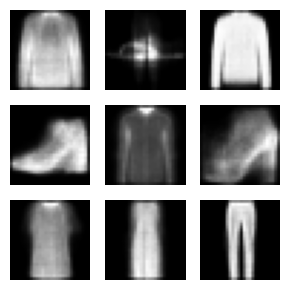

In [ ]:
sample_from_model(9, VAE)

# Traversing Latent Dimensions in VAE

This function explores how individual dimensions of the **latent space** influence the generated output. By systematically varying a latent dimensions , we can understand how each dimension encodes different aspects of the data.

create an arange for each of dimensions. Then decode all of these combinations and plot them in a single grid.

In [ ]:
def plot_along_axis(model):
    # create aranges
    z1 = torch.arange(-3, 3, 0.2).to(device)
    z2 = torch.arange(-3, 3, 0.2).to(device)
    num_z1 = z1.shape[0]
    num_z2 = z2.shape[0]
    num_z = num_z1 * num_z2
    sample = torch.zeros(num_z,  model.latent_dim).to(device)

    # create all possible combinations
    for i in range(num_z1):
        for j in range(num_z2):
            idx = i * num_z2 + j
            sample[idx][0] = z1[i]
            sample[idx][1] = z2[j]
    # decode and plot them
    with torch.no_grad():
        sample = model.decoder(sample).cpu().view(-1, 1, 28, 28)
    plot_multiple_images(num_z, sample)

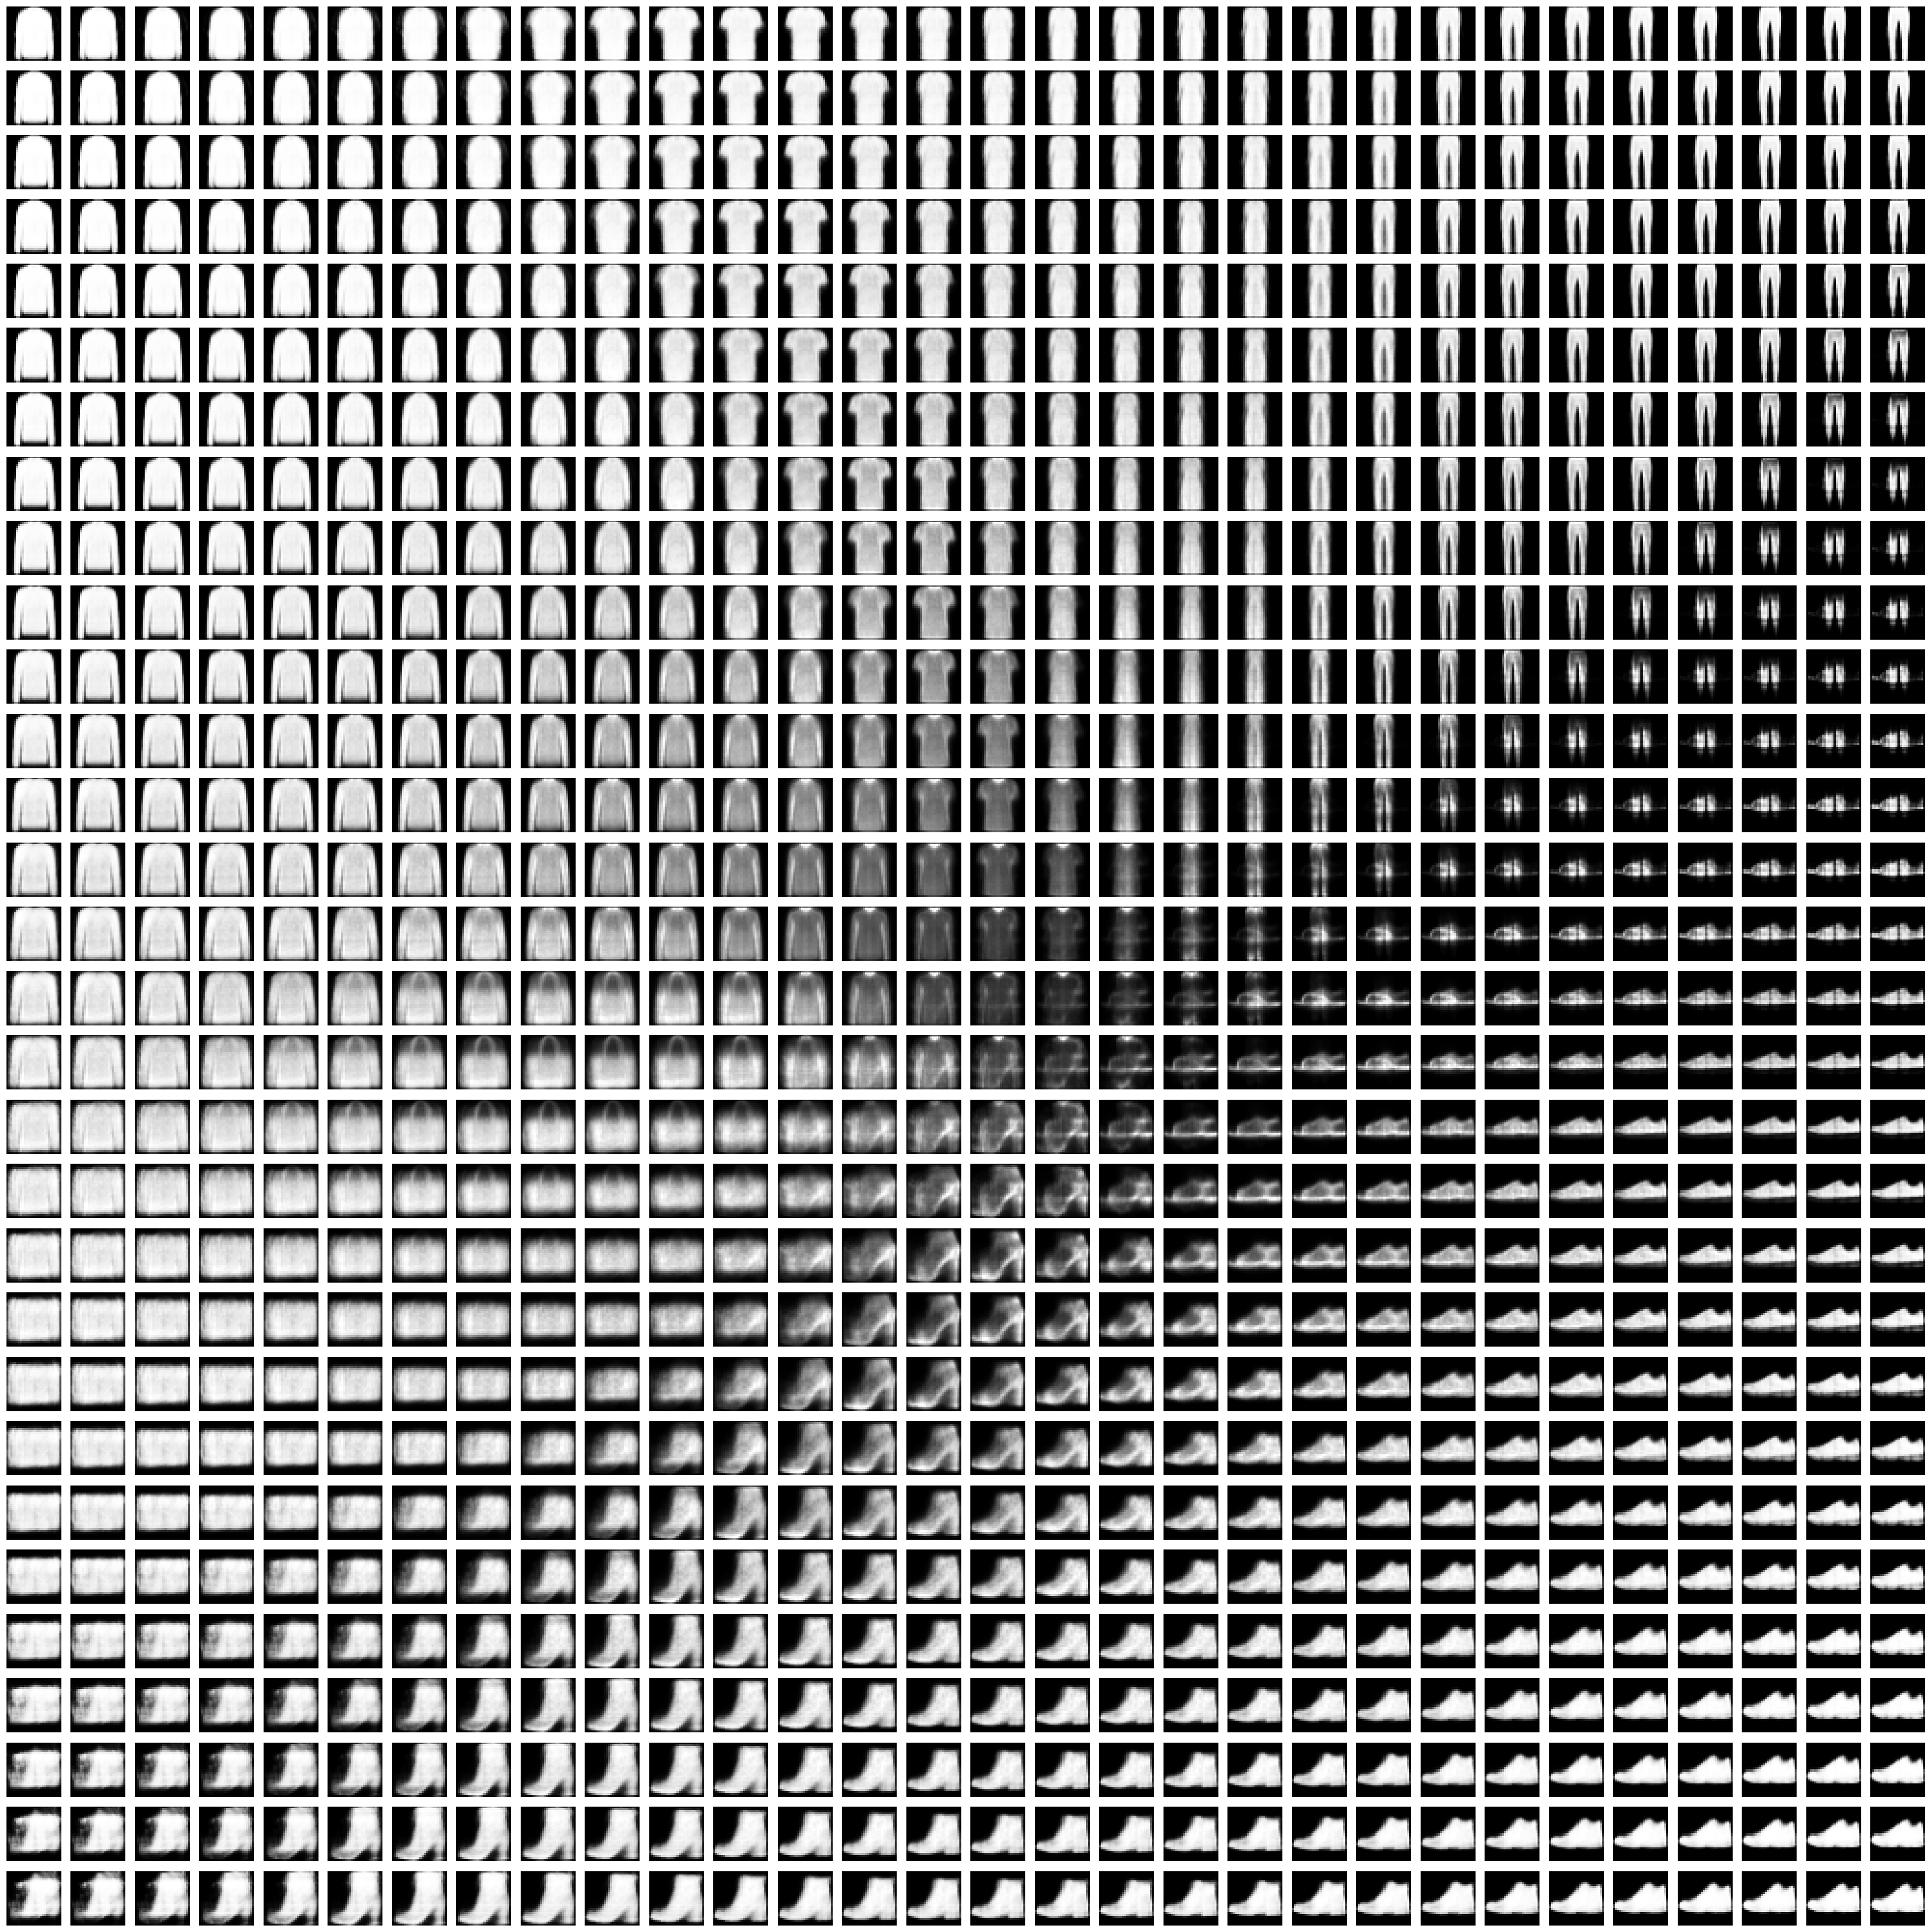

In [ ]:
plot_along_axis(VAE)

# Clustering the VAE Latent Space

This function analyzes the structure of the **latent space** in a Variational Autoencoder (VAE) by applying **K-Means clustering** and visualizing the results.

Extract the latent space of test dateset. Use KMeans to cluster this space and plot it in 2d space.

Plot one image from each cluster to see if they really represent labels from real dataset.

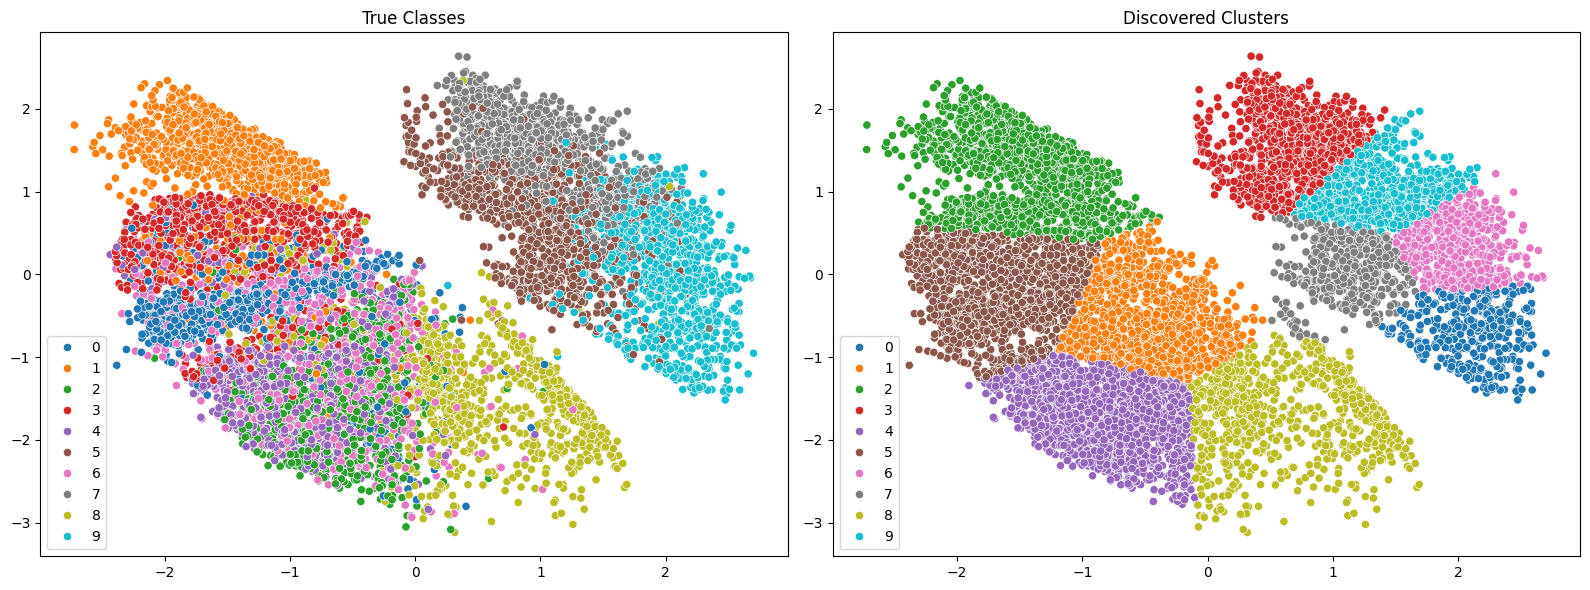

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

def cluster_latent_space(vae, dataloader, n_clusters, device):
    vae.eval()
    latents = []
    labels = []

    # Extract latent vectors
    with torch.no_grad():
        for img, label in dataloader:
            img = img.to(device).view(img.size(0), -1)
            mu, _ = vae.encode(img)
            latents.append(mu.cpu())
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
    clusters = kmeans.fit_predict(latents)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(x=latents[:, 0], y=latents[:, 1], hue=labels,
                    palette='tab10', ax=ax1)
    ax1.set_title('True Classes')

    sns.scatterplot(x=latents[:, 0], y=latents[:, 1], hue=clusters,
                    palette='tab10', ax=ax2)
    ax2.set_title('Discovered Clusters')

    plt.tight_layout()
    plt.show()
    return kmeans

kmeans = cluster_latent_space(VAE, test_loader, 10, device)

From each cluster, generate an image. Ideally, we expect to get 10 different images from 10 classes.

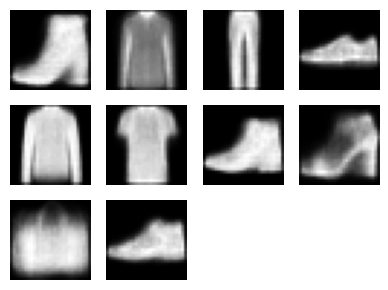

In [ ]:
# TODO
def generate_images_from_clusters(kmeans, vae, device, n_clusters=10):
    vae.eval()
    decoded_images = []
    with torch.no_grad():
        for i in range(n_clusters):
            cluster_center = torch.tensor(kmeans.cluster_centers_[i], dtype=torch.float32).to(device)
            recon = vae.decoder(cluster_center.unsqueeze(0)).cpu()
            recon_img = recon.view(1, 1, 28, 28)
            decoded_images.append(recon_img)

    all_images = torch.cat(decoded_images, dim=0)
    plot_multiple_images(n_clusters, all_images)

generate_images_from_clusters(kmeans, VAE, device, n_clusters=10)

# Adding a Classifier to VAE

This code extends the **Variational Autoencoder (VAE)** by adding a **classification head**. This allows the model to **predict class labels** from the latent space.

Add a linear layer that gets encoding of image as input and outputs the image's label. Change the forward function to also returns class logits. You can also add a classify function to returns just the class logits.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class VAEWithClassifier(VariationalAE):
    def __init__(self, num_classes):
        super().__init__()
        # Add a classification head
        self.classifier = nn.Linear(self.latent_dim, num_classes)

    def forward(self, x):
        # Get the encoded, decoded, mu, and log_var from the VAE
        # TODO
        # Pass the latent variable through the classifier
        recon_x, mu, logvar = super().forward(x)
        z = self.reparameterize(mu, logvar)
        class_logits = self.classifier(z)
        return class_logits

Load the pretrained vae weights, then use CrossEntropyLoss to train the model for a few epochs.



In [ ]:
def fine_tune_vae(vae_model, train_loader, test_loader, num_classes, num_epochs=4, learning_rate=1e-3, device=device):
    # Add the classification head to the VAE
    model = VAEWithClassifier(num_classes).to(device)

    # Load the pre-trained VAE weights
    # TODO
    model.load_state_dict(vae_model.state_dict(), strict=False)
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device).view(data.shape[0], -1), labels.to(device)

            # Zero the parameter gradients
            # TODO
            optimizer.zero_grad()
            # Forward pass
            # TODO
            logits = model(data)
            # Compute the loss
            loss = criterion(logits, labels)

            # Backward pass and optimize
            # TODO
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    return model

num_classes = 10
fine_tuned_model = fine_tune_vae(VAE, train_loader, test_loader, num_classes)

Epoch [1/4], Loss: 1.3214
Epoch [2/4], Loss: 0.7643
Epoch [3/4], Loss: 0.6300
Epoch [4/4], Loss: 0.5601


Evaluate fine tuned model on test data.

In [ ]:
fine_tuned_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        # TODO
        data, labels = data.to(device).view(data.shape[0], -1), labels.to(device)
        class_logits = fine_tuned_model(data)
        _, predicted = torch.max(class_logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 82.61%


### Adversarial Examples in Variational Autoencoders

In this experiment, we explore how a small, intentional perturbation to the input image can significantly alter the VAE's output, even though the input still looks visually similar.

We use the **Fast Gradient Sign Method (FGSM)** to generate an *adversarial image* that "fools" the VAE.

#### Steps:

1. Take a test image.
2. Compute the VAE’s reconstruction loss and backpropagate to get gradients w.r.t. the input.
3. Generate a perturbed image
4. Clamp pixel values to keep them in the valid range \([0, 1]\).
5. Feed both original and adversarial images through the VAE.
6. Compare:
   - Original vs Reconstruction
   - Adversarial vs Reconstruction

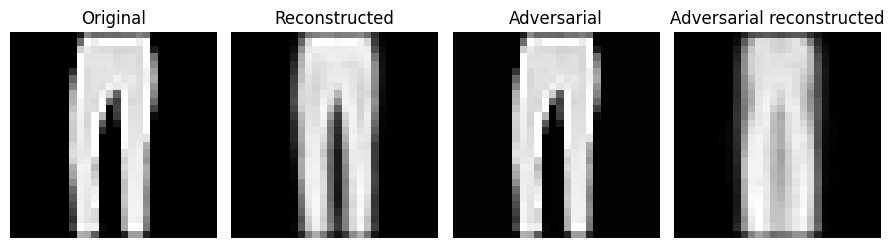

In [ ]:
# Get an input image from test_loader
# TODO
x, _ = next(iter(test_loader))
x = x.to(device)[0].unsqueeze(0)
x.requires_grad = True

# Forward pass
# TODO
recon_x, mu, logvar = VAE(x)
# Compute reconstruction loss
loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
loss.backward()

# Generate adversarial example (FGSM)
# TODO
x_adv = x + 0.01 * x.grad.sign()
x_adv = torch.clamp(x_adv, 0, 1)  # Ensure pixel range is valid

# Reconstruct adversarial example
# TODO
recon_adv, _, _ = VAE(x_adv)

# Plotting
def imshow(img, title):
    plt.imshow(img.squeeze().detach().cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(9, 4))
plt.subplot(1, 4, 1)
imshow(x, 'Original')

plt.subplot(1, 4, 2)
imshow(recon_x.view(28,28), 'Reconstructed')

plt.subplot(1, 4, 3)
imshow(x_adv.view(28,28), 'Adversarial')

plt.subplot(1, 4, 4)
imshow(recon_adv.view(28,28), 'Adversarial reconstructed')

plt.tight_layout()
plt.show()

###Fine-Tuning VAE for MNIST Digit Classification

In this experiment, we explore **cross-domain representation learning** by fine-tuning a **VAE originally trained on Fashion-MNIST** to classify digits from the **MNIST** dataset.

Although the VAE never saw digits during training, it learned general-purpose visual features (edges, strokes, textures). We now test whether these features can be **repurposed** to classify a completely different kind of visual data.

#### Steps:
1. The **Fashion-MNIST-trained VAE encoder** is reused as a feature extractor.
2. A **classifier head** is added to the encoder.
3. The model is fine-tuned on MNIST digit labels.
4. few epochs (one) is used to test how quickly it can adapt.

Calculate test accuracy on MNIST after fine-tuning.

In [ ]:
from torch.utils.data import DataLoader

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
num_classes = 10
fine_tuned_model = fine_tune_vae(VAE, train_loader, test_loader, num_classes, num_epochs=1)

Epoch [1/1], Loss: 1.1060


In [ ]:
fine_tuned_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device).view(data.shape[0], -1), labels.to(device)
        class_logits = fine_tuned_model(data)
        _, predicted = torch.max(class_logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 82.71%
